#Load & Understand Dataset

In [32]:
from google.colab import files

uploaded = files.upload()

Saving fake_reviews_dataset.csv to fake_reviews_dataset (1).csv


In [33]:
import pandas as pd

df = pd.read_csv("fake_reviews_dataset.csv")
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [34]:
df['category'].value_counts()

,count
category,
Kindle_Store_5,4730
Books_5,4370
Pet_Supplies_5,4254
Home_and_Kitchen_5,4056
Electronics_5,3988
Sports_and_Outdoors_5,3946
Tools_and_Home_Improvement_5,3858
Clothing_Shoes_and_Jewelry_5,3848
Toys_and_Games_5,3794


In [35]:
df['label'].value_counts()

,count
label,
CG,20216
OR,20216


In [36]:
df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

#Text Preprocessing

In [37]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['text_'].apply(clean_text)

df[['text_', 'clean_review']].head()

,text_,clean_review
0,"Love this! Well made, sturdy, and very comfor...",love this well made sturdy and very comfortabl...
1,"love it, a great upgrade from the original. I...",love it a great upgrade from the original ive ...
2,This pillow saved my back. I love the look and...,this pillow saved my back i love the look and ...
3,"Missing information on how to use it, but it i...",missing information on how to use it but it is...
4,Very nice set. Good quality. We have had the s...,very nice set good quality we have had the set...


#TF-IDF Vectorization

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X = vectorizer.fit_transform(df['clean_review'])

print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (40432, 5000)


#Task I: Product Category Classification

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

y_category = df['category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y_category, test_size=0.2, random_state=42, stratify=y_category
)

category_model = LogisticRegression(max_iter=1000, n_jobs=-1)
category_model.fit(X_train, y_train)

y_pred_cat = category_model.predict(X_test)

print("Category Classification Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

Category Classification Accuracy: 0.7707431680474837
                              precision    recall  f1-score   support

                     Books_5       0.74      0.77      0.76       874
Clothing_Shoes_and_Jewelry_5       0.79      0.79      0.79       770
               Electronics_5       0.80      0.78      0.79       798
          Home_and_Kitchen_5       0.66      0.74      0.70       811
              Kindle_Store_5       0.81      0.76      0.78       946
             Movies_and_TV_5       0.93      0.88      0.91       717
              Pet_Supplies_5       0.91      0.83      0.87       851
       Sports_and_Outdoors_5       0.61      0.64      0.63       789
Tools_and_Home_Improvement_5       0.68      0.70      0.69       772
            Toys_and_Games_5       0.83      0.82      0.83       759

                    accuracy                           0.77      8087
                   macro avg       0.78      0.77      0.77      8087
                weighted avg       

#Task 2: Fake Review Detection

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [41]:
X_dense = X.toarray()
X_tensor = torch.tensor(X_dense, dtype=torch.float32)
y_tensor = torch.tensor(y_fake.values, dtype=torch.float32)


from sklearn.model_selection import train_test_split

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_fake
)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [42]:
class FakeReviewNN(nn.Module):
    def __init__(self, input_dim):
        super(FakeReviewNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_dim = X_tensor.shape[1]
model = FakeReviewNN(input_dim)

In [43]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.3261
Epoch 2/5, Loss: 0.2176
Epoch 3/5, Loss: 0.1822
Epoch 4/5, Loss: 0.1409
Epoch 5/5, Loss: 0.0905


In [45]:
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        preds = (outputs >= 0.5).float()
        y_preds.extend(preds.tolist())
        y_true.extend(y_batch.tolist())

from sklearn.metrics import classification_report, accuracy_score

print("Neural Network Fake Review Detection Accuracy:", accuracy_score(y_true, y_preds))
print(classification_report(y_true, y_preds))

Neural Network Fake Review Detection Accuracy: 0.8825275132929393
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88      4044
         1.0       0.88      0.89      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



#Task 3: Word Cloud Generation

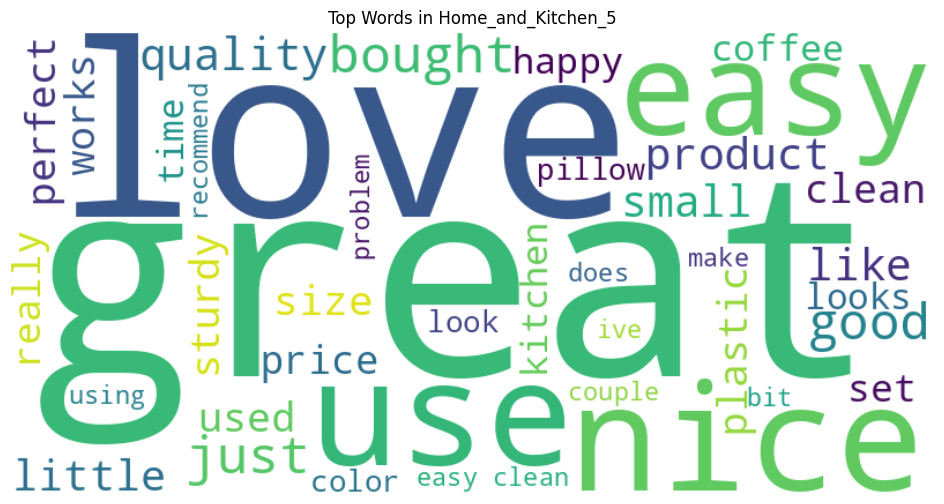

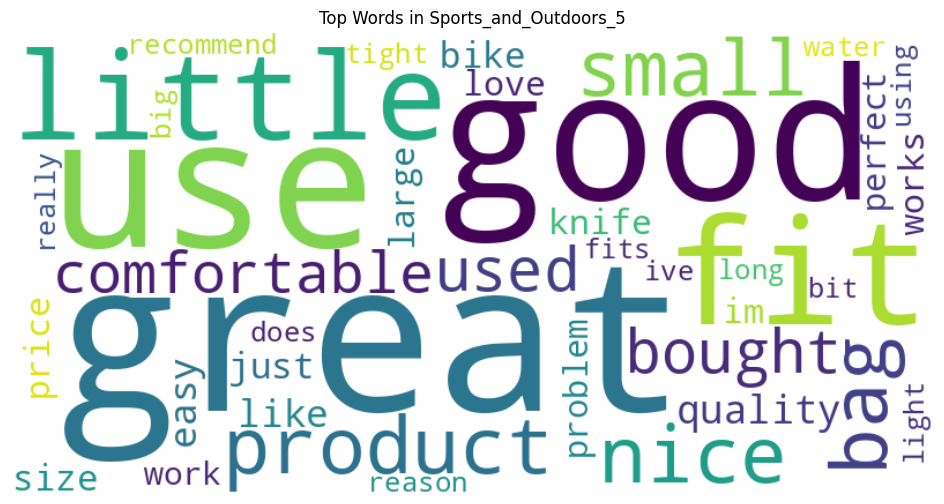

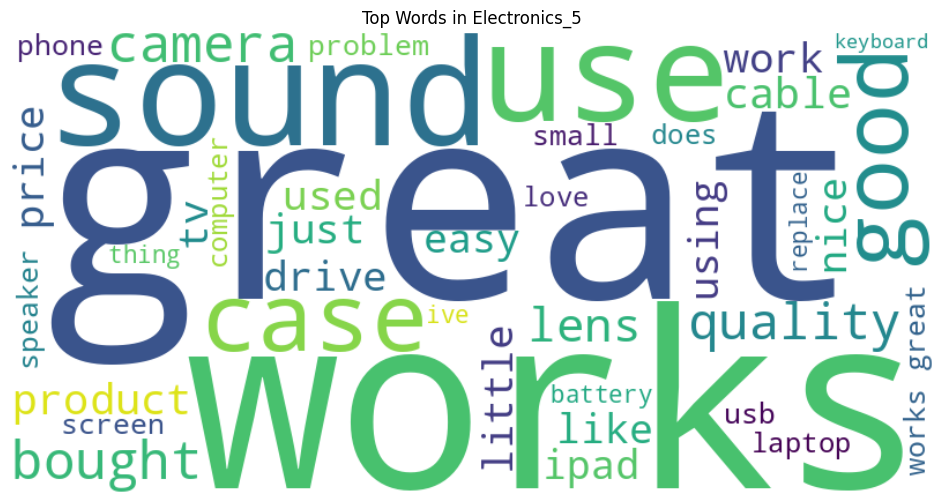

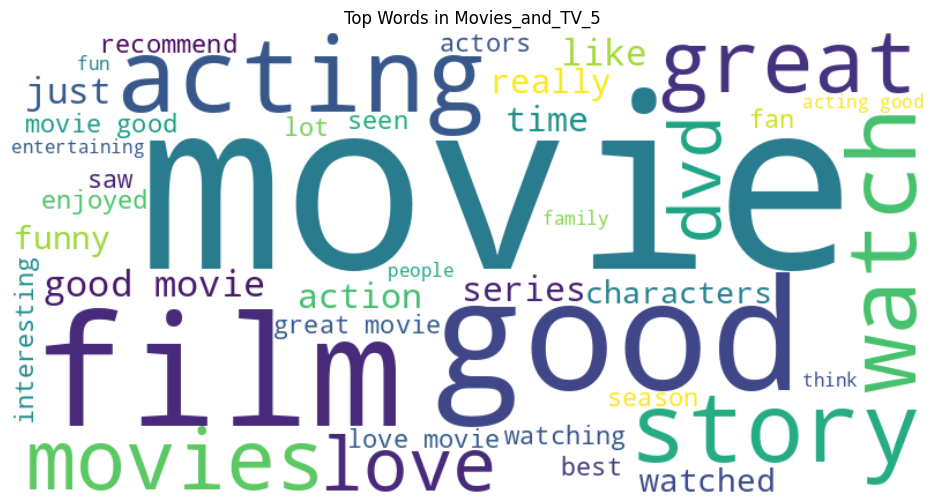

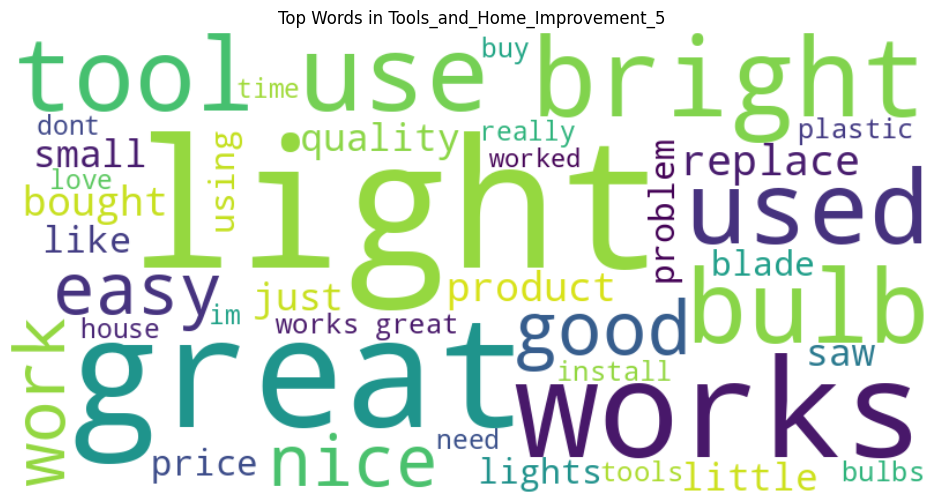

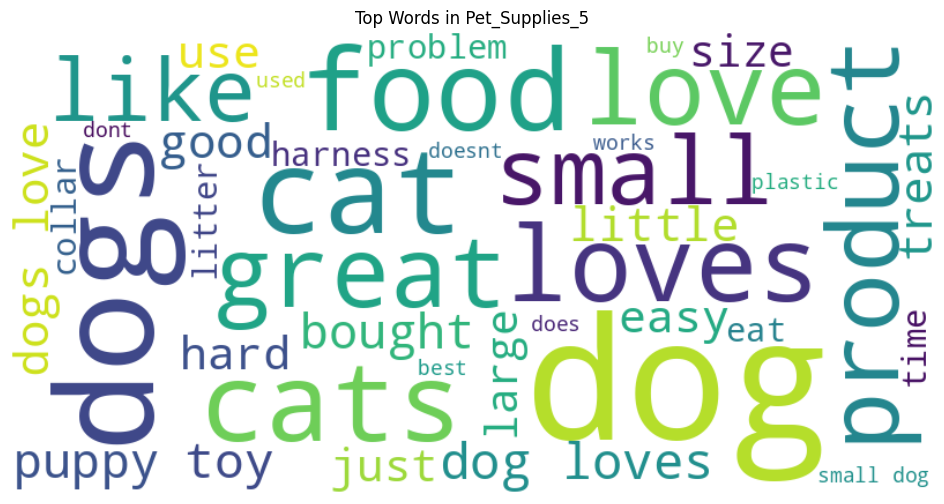

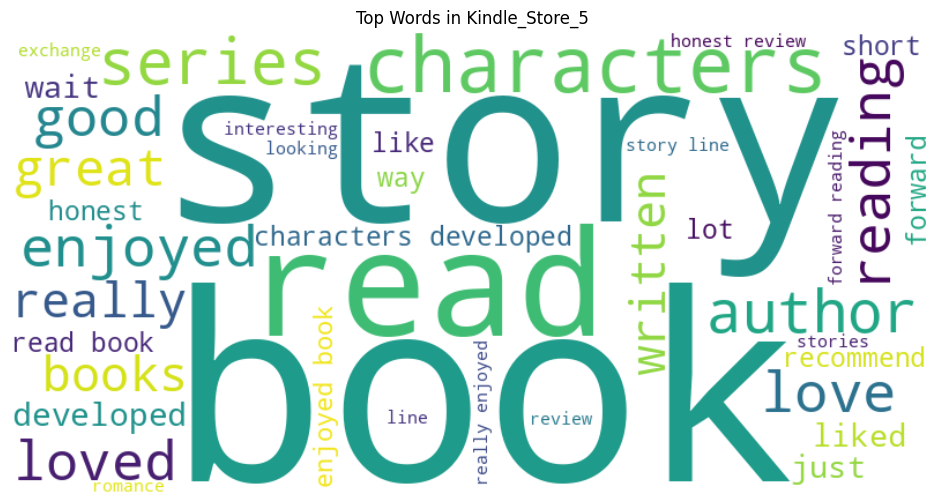

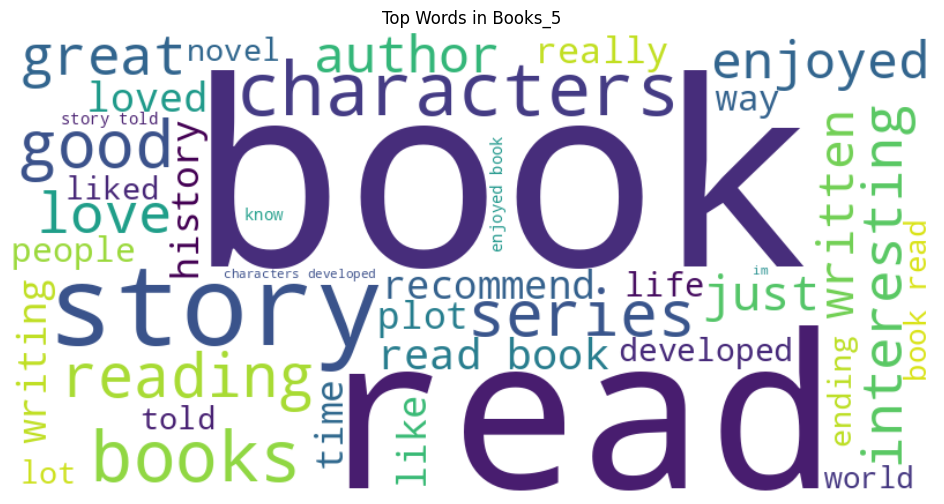

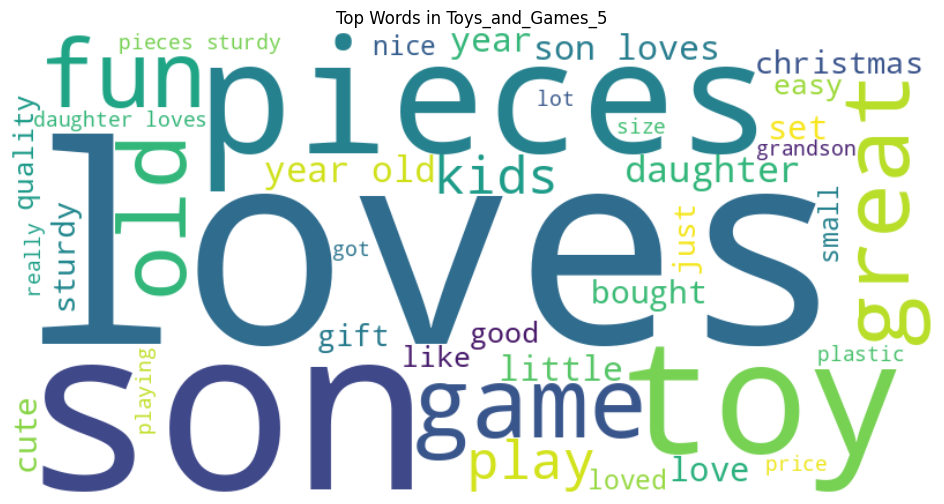

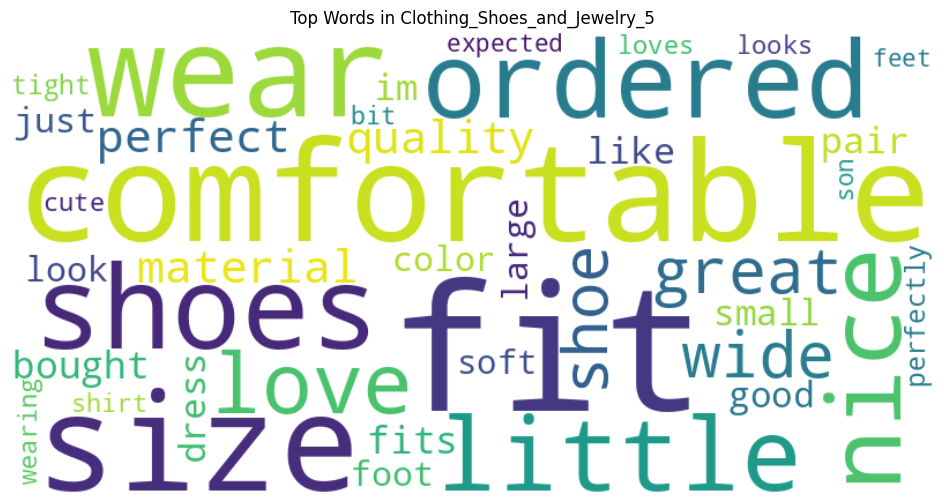

In [46]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import pandas as pd

categories = df['category'].unique()
feature_names = vectorizer.get_feature_names_out()

for cat in categories:
    cat_indices = df[df['category'] == cat].index
    X_cat = X[cat_indices].toarray()
    avg_tfidf = np.mean(X_cat, axis=0)
    top_n = 40
    top_indices = avg_tfidf.argsort()[-top_n:]
    top_words = {feature_names[i]: avg_tfidf[i] for i in top_indices}

    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(top_words)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Words in {cat}")
    plt.show()

 Observations and Potential Indicators of Fake Reviews:

1. Generic Positive Language: If a word cloud is dominated by very general positive adjectives like "great," "love," "perfect," "easy," "good," or "nice" without much specific detail about the product's features or use, it might be a flag. Fake reviews often use vague praise to promote a product without actually having used it.


2. Lack of Specificity: Genuine reviews often mention specific product features, how they used the product, or particular problems and solutions. If the word clouds show very few product-specific nouns or functional verbs, and instead are filled with broad descriptive terms, it could indicate a lack of genuine experience.


3. Repetition Across Categories: While some words are naturally common, if you notice the same generic positive words appearing prominently across many different and unrelated product categories, it could suggest a pattern of templated or inauthentic reviews. A reviewer trying to fake reviews for various products might reuse similar generic praise.


4. Emotional vs. Factual Language: Fake reviews, especially those designed to mislead, might lean heavily on emotional language (e.g., "amazing," "disappointed") without grounding it in factual product observations. While genuine reviews also have emotion, a high frequency of emotional words combined with a low frequency of specific details can be suspicious.


5. Extremes in Sentiment: An overwhelming presence of only extremely positive or extremely negative words (without nuance) could be a sign. Genuine experiences often involve a mix of pros and cons, or at least balanced observations.
For example, in a "Home_and_Kitchen" word cloud, if you see many words related to specific kitchen tasks, materials, or durability, that sounds more genuine. But if it's mostly words like "great purchase," "love it," "highly recommend," without much else, it could be less reliable.